In [8]:
import torch
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import numpy as np
import torch.nn as nn
import os
import glob
import datetime
from PIL import Image
import torchvision
from inception_evaluation import mnist_inception_score
from DCGAN import DCGAN_Generator, DCGAN_Discriminator, DCGAN_weights_init
import seaborn as sns
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inception Score Computation 

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G = DCGAN_Generator().to(device)
G.apply(DCGAN_weights_init)

D = DCGAN_Discriminator().to(device)
D.apply(DCGAN_weights_init)

n_latent = 100
size = 500
num = int(5000/size)
splits = 1

path = os.path.join(os.getcwd(), 'MNIST_Results')
fig_dir = os.path.join(path, 'Figs')
if not os.path.exists(fig_dir): os.makedirs(fig_dir)
    
scores = []
for step in np.arange(250, 7750, 250):
    file_paths = glob.glob(os.path.join(path, '*mnist*', 'Checkpoint', 'checkpoint_step_'+str(step)))
    file_paths = sorted(file_paths, key=lambda x: int(x.split('/')[-3].split('_')[0].split('mnist')[-1]))
    step_scores = []

    for fi in file_paths:
        checkpoint = torch.load(os.path.join(os.getcwd(), fi), 
                                map_location=torch.device('cpu'))
        G.load_state_dict(checkpoint['state_gen'])
        D.load_state_dict(checkpoint['state_dis'])

        G_generated = []
        for i in range(num):
            G_latent = torch.randn(size, n_latent, 1, 1).to(device)
            G_generated_sample = G(G_latent)
            G_generated.append(G_generated_sample.detach().cpu().numpy())
        G_generated = np.concatenate(G_generated)

        transformed = []
        for i in range(len(G_generated)):
            arr = G_generated[i].reshape((28,28))
            arr = np.array(Image.fromarray(arr).resize((32,32))).reshape(1, 32, 32)
            transformed.append(arr)

        transformed = torch.Tensor(transformed).to(device)
        score = mnist_inception_score(transformed, splits=splits)
        step_scores.append(score[0])

    print('finished step', step)
    scores.append(step_scores)

scores = np.array(scores)
np.save(os.path.join(fig_dir, 'inception_scores.npy'), scores)

finished step 250
finished step 500
finished step 750
finished step 1000
finished step 1250
finished step 1500
finished step 1750
finished step 2000
finished step 2250
finished step 2500
finished step 2750
finished step 3000
finished step 3250
finished step 3500
finished step 3750
finished step 4000
finished step 4250
finished step 4500
finished step 4750
finished step 5000
finished step 5250
finished step 5500
finished step 5750
finished step 6000
finished step 6250
finished step 6500
finished step 6750
finished step 7000
finished step 7250
finished step 7500


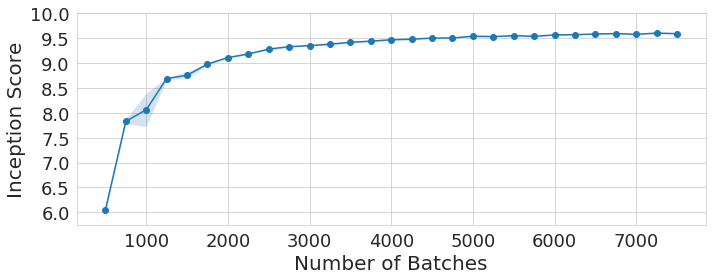

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(np.arange(500, 7750, 250), np.mean(scores, axis=1)[1:], '-o')
plt.fill_between(np.arange(250, 7750, 250)[1:], scores.mean(axis=1)[1:]-scores.std(axis=1)[1:]/np.sqrt(scores.shape[1]), 
                 scores.mean(axis=1)[1:]+scores.std(axis=1)[1:]/np.sqrt(scores.shape[1]), alpha=.2)
plt.xlabel('Number of Batches', fontsize=20)
plt.ylabel('Inception Score', fontsize=20)
plt.ylim(5.75, 10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'inception_score.png'))

## Samples

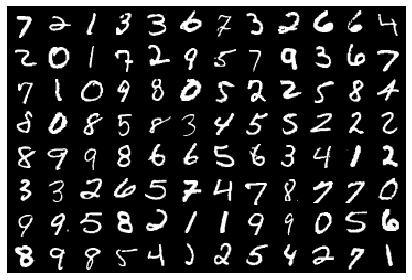

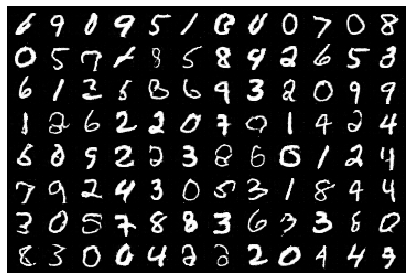

In [10]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

rank = 4
sorted_final_scores = sorted([(index, score) for index,score in enumerate(scores[-1])], key=lambda x: x[1], reverse=True)
index = sorted_final_scores[rank][0]
file_paths = glob.glob(os.path.join(path, '*mnist*', 'Checkpoint', 'checkpoint_step_7500'))
file_paths = sorted(file_paths, key=lambda x: int(x.split('/')[-3].split('_')[0].split('mnist')[-1]))
seed_num = file_paths[index].split('/')[-3].split('_')[0].split('mnist')[-1]
fi_fake = file_paths[index]
fi_real = glob.glob(os.path.join(path, '*mnist'+seed_num+'*', 'Data', 'real_sample.npy'))[0]

num = 96
nrow = 12

real = torch.Tensor(np.load(fi_real)[:num])
img = torchvision.utils.make_grid(real, nrow=nrow, normalize=True)
npimg = img.cpu().detach().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'real_sample.png'))
plt.show()

checkpoint = torch.load(os.path.join(os.getcwd(), fi_fake), 
                        map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['state_gen'])
D.load_state_dict(checkpoint['state_dis'])
G_latent = torch.randn(num, n_latent, 1, 1).to(device)
G_generated_sample = G(G_latent)
img = torchvision.utils.make_grid(G_generated_sample, nrow=nrow, normalize=True)
npimg = img.cpu().detach().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'fake_sample.png'))
plt.show()